# Tutorial for R users

In this tutorial we will enrich *Acropora digitifera* observations with bathymetry information.
Please make sure you already followed the [installation instructions](https://geoenrich.readthedocs.io/en/latest/r-install.html).

Here is a summary of the main steps:
- **Loading your dataset** and giving it a name (called reference here).
- **Performing data enrichment** by specifying your dataset reference, the environmental variable you need, etc.
- **Exporting the downloaded data** to the format you require.


## 1. Load your occurrence data

First import all functions from geoenrich

In [ ]:
library(reticulate)

os <- import("os")
dataloader <- import("geoenrich.dataloader", convert=FALSE)
enrichment <- import("geoenrich.enrichment", convert=FALSE)
exports <- import("geoenrich.exports", convert=FALSE)

**Three input formats are accepted. You can follow the instructions that match your format:**

#### A. DarwinCore archive

A DarwinCore archive is bundled into the package for user testing (GBIF Occurrence Download [10.15468/dl.megb8n](https://doi.org/10.15468/dl.megb8n)).
If you don't have a dataset and you don't want to register to GBIF yet you can use this one.

In [3]:
example_path <- paste( os$path$split(dataloader$'__file__')[[1]],
                      '/data/AcDigitifera.zip', sep = '')
geodf <- dataloader$open_dwca(path = example_path)

#### B. Georeferenced points (csv format)

Fill in the path to your csv and the compulsory column names.

In [ ]:
geodf <- dataloader$import_occurrences_csv( path = '', id_col = '', date_col = '',
                                            lat_col = '', lon_col = '')

#### C. Area bounds (csv format)

See [documentation](https://geoenrich.readthedocs.io/en/latest/dataloader.html#geoenrich.dataloader.load_areas_file) for information about input file format.

In [ ]:
example_path <- paste( os$path$split(dataloader$'__file__')[[1]] ,
                      '/data/areas.csv', sep = '')
geodf <- dataloader$load_areas_file(example_path)

#### For all formats: Choose a dataset reference and associate it to your dataset

In [ ]:
dataset_ref <- 'ac_digitifera'
enrichment$create_enrichment_file(geodf, dataset_ref)

## 2. Enrich

#### Define enrichment scope

- var_id: Pick a variable id from the catalog
- geo_buff: the buffer around the occurences (in kilometers). Choose 0 to obtain nearest values.
- time_buff: Choose a temporal buffer. In this case we download data from 7 days before the occurrence date, to the occurrence date. time_buff is only used for variables that have a time dimension

In [ ]:
var_id <- 'bathymetry'
dataset_ref <- 'ac_digitifera'
geo_buff <- 115
time_buff <- c(-7L, 0L)

#### Start enrichment

The slice argument allows you to only run the enrichment on a subset of the points.

In [ ]:
enrichment$enrich(dataset_ref, var_id, geo_buff,
                  time_buff, slice = c(0L,100L))

Check the enrichment progress

In [ ]:
enrichment$enrichment_status(dataset_ref)

## 3. Retrieve and export downloaded data

Select the dataset reference and the variable that you want to export. Then you can choose one of four options:

In [ ]:
dataset_ref <- 'ac_digitifera'
var_id <- 'bathymetry'

#### A. Export variable statistics for the whole dataset

In [9]:
exports$produce_stats(dataset_ref, var_id, out_path = './')

#### B. Export data as a raster layer for a given occurrence

In [ ]:
ids <- py_to_r(enrichment$read_ids(dataset_ref))
occ_id <- ids[[1]] # first occurrence of the dataset

exports$export_raster(dataset_ref, occ_id, var_id, path = './')

#### C. Export data as a png file for a given occurrence

In [ ]:
ids <- py_to_r(enrichment$read_ids(dataset_ref))
occ_id <- ids[[1]] # first occurrence of the dataset

exports$export_png(dataset_ref, occ_id, var_id, path = './')

#### D. Retrieve the raw data (and plot it)

Required libraries: ggplot2, reshape2, sf, pals

In [ ]:
library(ggplot2)
library(reshape2)
library(sf)
library(pals)

In [ ]:
# Select an idea from the dataset

ids <- enrichment$read_ids(dataset_ref)
occ_id <- ids[[1]] # first occurrence of the dataset


output <- exports$retrieve_data(dataset_ref, occ_id, var_id, shape = 'buffer')

data <- py_to_r(output[["values"]])
unit <- output$unit
coords <- py_to_r(output[["coords"]])

# Retrieve coordinates
for (c in coords){
    if (c[[1]] == 'latitude'){
        lats = c[[2]]}
    if (c[[1]] == 'longitude'){
        longs = c[[2]]}}

# Retrieve coordinates of the occurrence
occurrences <- read.csv(file = paste(enrichment$biodiv_path, '/', dataset_ref,  '.csv', sep = ''), row.names = 1)
occ_point <- st_coordinates(st_as_sf(occurrences[as.character(occ_id),], wkt = 'geometry'))

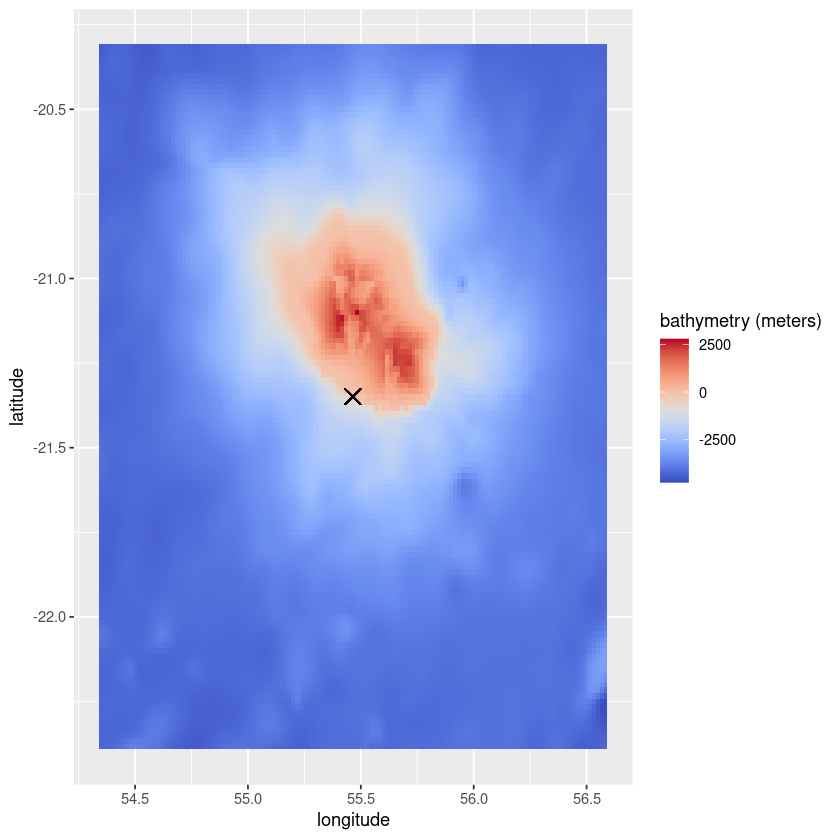

In [15]:
colnames(data) <- longs
rownames(data) <- lats
data_df <- melt(data)
colnames(data_df) <- c('latitude', 'longitude', var_id)
title <- paste(var_id, ' (', unit, ')', sep = '')
ggplot(data = data_df, aes(x=longitude, y=latitude, fill=eval(as.name(var_id)))) + 
       geom_tile()+
       scale_fill_gradientn(title,colours=coolwarm(100), guide = "colourbar")+
       geom_point(aes(x=occ_point[[1]], y=occ_point[[2]]), shape=4, size = 4)